In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Reshape, Conv2DTranspose
from tensorflow.keras.utils import plot_model

In [2]:
(trainx, trainy),(testx, testy) = tf.keras.datasets.mnist.load_data() 

In [3]:
trainx.shape

(60000, 28, 28)

In [4]:
trainx[0].shape

(28, 28)

### Basic overview
The model which we are going to build uses the images in the training dataset as the basis for training a simple Generative Adversarial Network
- **Generator**: It will eventually try to generate new grayscale images of the digits 0-9 as close as possible to the digits in the dataset
- **Discriminator**: It will try to distinguinsh between the images generated by GAN and the real images from the dataset


### Process
We intend to first build the models, build the *discriminator* model first followed by the *generator* model and then club them so as to train the overall model so that we achieve what we're tying to do


#### Discriminator
- **Requirements**: It must be able to take an image as an input from the dataset and must be able to output a binary classification $(1/0)$ judging whether the image is a real image or generated by the generator 
- We will build a simple model which is purely a convolutional type

In [5]:
model = Sequential([
    Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1), activation = 'relu'),
    Dropout(0.4),
    Conv2D(64, (3,3), strides=(2, 2), padding='same', activation = 'relu'),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

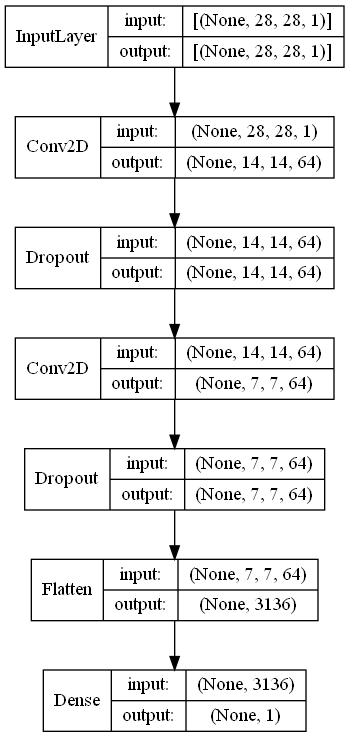

In [7]:
plot_model(model,show_shapes=True,show_layer_names=False)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)                 3137      
                                                                 
Total params: 40,705
Trainable params: 40,705
Non-traina

In [9]:
# expanding the dimensions because the CNN layer expects 
#the dimensions of the input to be 3 dimensional and the image is of 2d (28x28)
X = np.expand_dims(trainx, axis=-1)

In [10]:
X = X.astype('float32')
X = X/255

In [11]:
# A function that takes in input the dataset , noofsample and returns those number of samples from real dataset along
# with ylabel as 1 because these small real data sample will later be used to train the GAN model
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [12]:
# A function that takes in input the noofsamples and returns those number of arbitrarily generated samples along
# with ylabel as 0 because these small fake data sample will later be used to train the GAN model
def generate_fake_samples(n_samples):
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    y = np.zeros((n_samples, 1))
    return X, y

Training the discriminator model, we aren't using the $model.fit()$ function because we entering the number of epochs manually and we aren't actually training the model on whole dataset

In [13]:
# training the discriminator model
# we aren't using the model.fit() function because we are manually
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [14]:
train_discriminator(model, X)

>1 real=61% fake=1%
>2 real=94% fake=32%
>3 real=94% fake=98%
>4 real=87% fake=100%
>5 real=82% fake=100%
>6 real=70% fake=100%
>7 real=70% fake=100%
>8 real=73% fake=100%
>9 real=77% fake=100%
>10 real=88% fake=100%
>11 real=95% fake=100%
>12 real=95% fake=100%
>13 real=99% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%
>21 real=100% fake=100%
>22 real=100% fake=100%
>23 real=100% fake=100%
>24 real=100% fake=100%
>25 real=100% fake=100%
>26 real=100% fake=100%
>27 real=100% fake=100%
>28 real=100% fake=100%
>29 real=100% fake=100%
>30 real=100% fake=100%
>31 real=100% fake=100%
>32 real=100% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake

#### Generator
- **Requirements**: It must be able to generate an image as close as possible to the images in dataset and must be able to fool the discriminator
- The generator will consist of a deep neural network where the deep neural network is responsibe for the transformation of the prior distribution to the desired images distribution in the dataset.
- We will build a simple model which consists of both a convolutional type and dense layers 
- A random prior sampler should also be created of random data sampling. Generally sampling is done from a guassian distribution in some random $n$ dimensions and then converting the array to the desired size of the input
- The training of generator is done a bit differently unlike the initial training of the discriminator

In [15]:
# random generator for 100*1 points in the latent space of 100 rv guassian
def generate_latent_points(dimensions, n_samples):
    # generate points in the dimensions
    x_input = np.random.randn(dimensions * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, dimensions)
    return x_input

In [16]:
generatormodel = Sequential([
    # took 128*7*7 because it'll later be reshaped by the model to 7*7 images which later will be upscaled to 14*14 and then 
    # 28*28 later which in the end all the 128 images obtained via various filters will be merged into 1
    # also we are trying to map the guassian vector of 100 dimension we sample 28*28 image via neural network
    Dense(128*7*7, input_dim=100, activation = 'relu'),
    Reshape((7, 7, 128)),
    # upsample to 14x14
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation = 'relu'),
    # upsample to 28x28
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation = 'relu'),
    Conv2D(1, (7,7), activation='sigmoid', padding='same'),
])

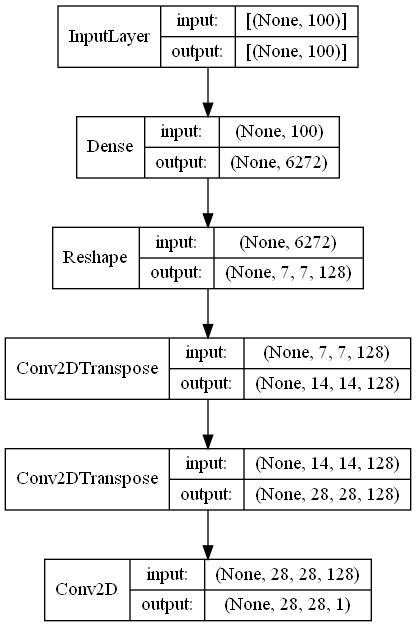

In [17]:
plot_model(generatormodel,show_shapes=True,show_layer_names=False)

In [18]:
generatormodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         6273      
                                                                 
Total params: 1,164,289
Trainable params: 1,164,289
No

In [19]:
# modifying the generate_fake_samples function so that the fake samples that will be generated will be coming from the 
# generator model
def generate_fake_samples(g_model, n_samples):
    x_input = generate_latent_points(100, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0) because these are the fake images because these are being generated by the generator
    y = np.zeros((n_samples, 1))
    return X, y

### Training the generator model
Training the generator model takes a bit of a thought because
- It must be trained based on the adversarial relationship between the generator and the discriminator model
- The weights in the generator model must be updated well when the discriminator is able to distinguish between the real and fake images well and the weight update should be less when the discriminator is not able to distinguish between the real and fake images well.

Simplest approach is to create a new model which holds both the **generator** and **discriminator** model such that it takes input from the latent space of points and feeds it into generator, which then sends the input image into discriminator model and later capable of updating the weights of the generator
The discriminator model
- The discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each
- Hence, the discriminators parameters will be marked as non-trainable

**Note**: When the generator is trained as part of the GAN model, we are going to mark the generated samples as real because when the discriminator model classifies the generated images as fake, i.e, as 0, and when we mark as the images as real i.e, 1, the model will think of it as a large error and the parameters are updated well and when the discriminator classifies it as real, i.e, 1, the model won't see that as an error and the parameters won't be updated that well, as desired

In [20]:
# function that clubs both generator model and the discriminator model along with making the discriminator model parameters as
# non-trainable
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [21]:
gan_model = define_gan(generatormodel, model)

In [22]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


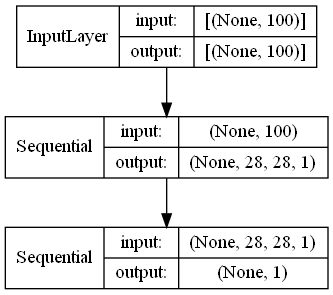

In [23]:
plot_model(gan_model,show_shapes=True,show_layer_names=False)

To train the model as a whole, we would train the $GAN$ model along with training of the discriminator model because we had declared the discriminator model's parameters in the $GAN$ model as non-trainable

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=15, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):                                                  # manually enumerating epochs
        print("Epoch ", i)                                          # just to measure the progress
        for j in range(bat_per_epo):                                           # enumerating batches over the training set
            print("Batch ", j)
            X_real, y_real = generate_real_samples(dataset, half_batch)        # getting randomly selected 'real' samples
            X_fake, y_fake = generate_fake_samples(g_model,  half_batch)  # generating 'fake' examples
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))              # creating training set for the discriminator
            d_loss, _ = d_model.train_on_batch(X, y)                           # updating discriminator model weights
            X_gan = generate_latent_points(latent_dim, n_batch)  # preparing points in latent space as input for the generator
            y_gan = np.ones((n_batch, 1))                          # creating inverted labels for the fake samples
            g_loss = gan_model.train_on_batch(X_gan, y_gan)    # updating the generator via the discriminator's error   

In [ ]:
train(generatormodel, model, gan_model, X, 100)

Epoch  0
Batch  0
Batch  1
Batch  2
Batch  3
Batch  4
Batch  5


### Evaluating the GAN model
There's no proper way to evaluate the performance of the GAN model, its just going along the training time and visualising various images for clarity

In [ ]:
fakesamples = generate_fake_samples(generatormodel, n_samples)
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(fakesamples[i, :, :, 0], cmap='gray_r')
pyplot.show()